In [ ]:
!pip install coverage

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 5.0 MB/s eta 0:00:00


#Test Fuzzer

In [ ]:
import random
import string
import coverage
from collections import defaultdict
import tempfile
import os


In [ ]:
import os
import tempfile

coverage_data_path = os.path.join(tempfile.gettempdir(), ".coverage")
if os.path.exists(coverage_data_path):
    os.remove(coverage_data_path)  # Remove old data


In [ ]:
from collections import defaultdict

class CoverageGuidedFuzzer:
    def __init__(self, target_function, seed_inputs, max_iterations=100):
        self.target_function = target_function
        self.seed_population = seed_inputs
        self.max_iterations = max_iterations
        self.coverage_data = defaultdict(int)

    def mutate_input(self, input_str):
        """ Improve mutation strategy to explore more paths. """
        mutation_type = random.choice(["flip", "replace", "append", "delete", "insert", "reverse"])
        input_list = list(input_str)

        if mutation_type == "flip" and input_list:
            index = random.randint(0, len(input_list) - 1)
            input_list[index] = chr(random.randint(32, 126))
        elif mutation_type == "replace" and input_list:
            index = random.randint(0, len(input_list) - 1)
            input_list[index] = random.choice(string.ascii_letters)
        elif mutation_type == "append":
            input_list.append(random.choice(string.ascii_letters))
        elif mutation_type == "delete" and input_list:
            index = random.randint(0, len(input_list) - 1)
            del input_list[index]
        elif mutation_type == "insert":
            index = random.randint(0, len(input_list))
            input_list.insert(index, random.choice(string.ascii_letters))
        elif mutation_type == "reverse":
            input_list.reverse()

        return "".join(input_list)

    def measure_coverage(self, input_str):
        """ Run the program using a subprocess to avoid Jupyter coverage issues. """
        script_content = f"""
import coverage
cov = coverage.Coverage(data_file="{tempfile.gettempdir()}/.coverage")
cov.start()

def target_function(input_str):
    if "bug" in input_str:
        raise ValueError("Found a bug!")
    elif "error" in input_str:
        print("Potential issue detected.")
    elif "fail" in input_str:
        print("System failure detected!")
    elif "1234" in input_str:
        print("Processing sensitive input...")
    else:
        print(f"Processing {{input_str}}")

target_function("{input_str}")

cov.stop()
cov.save()
        """

        script_path = os.path.join(tempfile.gettempdir(), "temp_script.py")
        with open(script_path, "w") as f:
            f.write(script_content)

        # Run the script with coverage
        subprocess.run(["python3", script_path], capture_output=True)

        # Extract coverage info
        cov = coverage.Coverage(data_file=f"{tempfile.gettempdir()}/.coverage")
        cov.load()
        covered_lines = cov.analysis(script_path)[1]

        print(f"[DEBUG] Covered lines: {covered_lines}")
        return len(covered_lines)

    def run(self):
        """ Run the fuzzing process with coverage tracking output """
        seen_coverage = set()

        for i in range(self.max_iterations):
            seed = random.choices(self.seed_population, weights=[self.coverage_data[s] + 1 for s in self.seed_population], k=1)[0]
            mutated_input = self.mutate_input(seed)
            new_coverage = self.measure_coverage(mutated_input)

            if new_coverage not in seen_coverage:
                seen_coverage.add(new_coverage)
                self.seed_population.append(mutated_input)
                self.coverage_data[mutated_input] = new_coverage
                print(f"[Iteration {i+1}] New input '{mutated_input}' increased coverage to {new_coverage}.")

        print("Fuzzing complete.")

In [ ]:
# Example usage
def sample_function(input_str):
    if "bug" in input_str:
        raise ValueError("Found a bug!")
    elif "error" in input_str:
        print("Potential issue detected.")
    elif "warning" in input_str:
        print("Non-critical warning.")
    elif "fail" in input_str:
        print("System failure detected!")
    elif "1234" in input_str:
        print("Processing sensitive input...")
    elif input_str.startswith("admin"):
        print("Admin privileges detected.")
    elif "debug" in input_str and "log" in input_str:
        print("Debugging mode enabled.")
    elif "safe" in input_str or "secure" in input_str:
        print("Security mode active.")
    elif len(input_str) > 10:
        print("Handling long input...")
    elif input_str.isdigit():
        print("Processing numeric input.")
    elif "!" in input_str and "?" in input_str:
        print("Detected a confused input!")
    else:
        print(f"Processing {input_str}")




fuzzer = CoverageGuidedFuzzer(sample_function, ["test"], max_iterations=50)
fuzzer.run()


[DEBUG] Covered lines: [2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18, 20, 21]
[Iteration 1] New input 't7st' increased coverage to 16.
[DEBUG] Covered lines: [2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18, 20, 21]
[DEBUG] Covered lines: [2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18, 20, 21]
[DEBUG] Covered lines: [2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18, 20, 21]
[DEBUG] Covered lines: [2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18, 20, 21]
[DEBUG] Covered lines: [2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18, 20, 21]
[DEBUG] Covered lines: [2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18, 20, 21]
[DEBUG] Covered lines: [2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18, 20, 21]
[DEBUG] Covered lines: [2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18, 20, 21]
[DEBUG] Covered lines: [2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18, 20, 21]
[DEBUG] Covered lines: [2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18, 20, 21]
[DEBUG] Covered lines: [2, 3, 4, 6, 7, 8, 9, 10, 11,

In [ ]:
import matplotlib.pyplot as plt

def plot_coverage_growth(coverage_data):
    iterations = list(range(1, len(coverage_data) + 1))
    coverage_values = list(coverage_data.values())

    plt.plot(iterations, coverage_values, marker='o', linestyle='-')
    plt.xlabel("Iteration")
    plt.ylabel("Coverage Score")
    plt.title("Coverage Growth Over Time")
    plt.show()


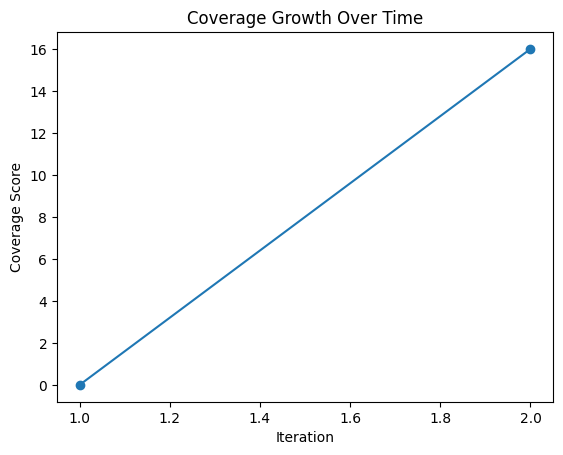

In [ ]:
plot_coverage_growth(fuzzer.coverage_data)


#Income Tax Calculator

In [63]:
import random
import coverage
import tempfile
from collections import defaultdict
import importlib.util

In [65]:
module_path = "/content/tax_functions.py"
module_name = "tax_module"
spec = importlib.util.spec_from_file_location(module_name, module_path)
tax_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(tax_module)


oldtax = tax_module.oldtax
newtax = tax_module.newtax

In [86]:
class IncomeTaxFuzzer:
    def __init__(self, max_iterations=50):
        self.max_iterations = max_iterations
        self.coverage_tracker = coverage.Coverage(branch=True, data_file=tempfile.gettempdir() + "/.coverage")
        self.coverage_data = defaultdict(int)

        self.seed_population = [
            0, 249999, 250000, 250001, 500000, 750000, 999999, 1000000, 2500000,
            5000000, 10000000, -1, -100, -100000, 999999999
        ]


    def mutate_input(self, input_data):
        """ Mutate the taxable income """
        #mutation_type = random.choice(["increase", "decrease", "randomize", "zero", "negative"])
        mutation_type = random.choice(["increase", "decrease", "randomize"])

        mutated_input = input_data

        if mutation_type == "increase":
            mutated_input += random.randint(100, 100000)
        elif mutation_type == "decrease":
            mutated_input = max(0, mutated_input - random.randint(100, 100000))
        elif mutation_type == "randomize":
            mutated_input = random.randint(-500000, 10000000)
        elif mutation_type == "zero":
            mutated_input = 0
        elif mutation_type == "negative":
            mutated_input = -random.randint(1000, 500000)

        return mutated_input

    def run(self):
        """ Execute the fuzzing process """
        error_log_path = "fuzzer_errors.log"
        with open(error_log_path, "w") as f:
            f.write("Starting fuzzing tests...\n")

        for i in range(self.max_iterations):
            seed = random.choice(self.seed_population)
            mutated_input = self.mutate_input(seed)

            try:
                tax_old = oldtax(mutated_input)
                tax_new = newtax(mutated_input)

                # Check if the tax is within expected range
                if tax_old < 0 or tax_new < 0:
                    error_message = f"[ERROR] Negative tax found for income {mutated_input}\n"
                    print(error_message)
                    with open(error_log_path, "a") as f:
                        f.write(error_message)

                # Check if tax computation is consistent
                if mutated_input < 250000 and (tax_old > 0 or tax_new > 0):
                    error_message = f"[ERROR] Unexpected tax for non-taxable income: {mutated_input}\n"
                    print(error_message)
                    with open(error_log_path, "a") as f:
                        f.write(error_message)

                print(f"[Iteration {i+1}] Income: {mutated_input} | Old Tax: {tax_old} | New Tax: {tax_new}")

            except Exception as e:
                error_message = f"[EXCEPTION] Error at {mutated_input}: {e}\n"
                print(error_message)
                with open(error_log_path, "a") as f:
                    f.write(error_message)

        with open(error_log_path, "a") as f:
          f.write("Fuzzing completed. No errors detected.\n")

        print(f"Fuzzing complete. Errors (if any) logged to {error_log_path}")



In [87]:
if __name__ == "__main__":
    fuzzer = IncomeTaxFuzzer(max_iterations=50)
    fuzzer.run()

[Iteration 1] Income: 8688363 | Old Tax: 2515769.256 | New Tax: 2437769.256
[Iteration 2] Income: 7773697 | Old Tax: 2230393.464 | New Tax: 2152393.464
[Iteration 3] Income: 4554361 | Old Tax: 1225960.632 | New Tax: 1147960.632
[Iteration 4] Income: 7033549 | Old Tax: 1999467.288 | New Tax: 1921467.288
[Iteration 5] Income: 4426178 | Old Tax: 1185967.5359999998 | New Tax: 1107967.5359999998
[Iteration 6] Income: 1174447 | Old Tax: 171427.464 | New Tax: 114284.976
[Iteration 7] Income: 222603 | Old Tax: 0.0 | New Tax: 0.0
[Iteration 8] Income: 247518 | Old Tax: 0.0 | New Tax: 0.0
[Iteration 9] Income: 221498 | Old Tax: 0.0 | New Tax: 0.0
[Iteration 10] Income: 438542 | Old Tax: 9804.184000000001 | New Tax: 9804.184000000001
[Iteration 11] Income: 5044715 | Old Tax: 1378951.08 | New Tax: 1300951.08
[Iteration 12] Income: 655903 | Old Tax: 45427.824 | New Tax: 29213.912
[Iteration 13] Income: 0 | Old Tax: 0.0 | New Tax: 0.0
[Iteration 14] Income: 4942123 | Old Tax: 1346942.376 | New Tax: 

In [88]:
!ls -la /content/


total 84
drwxr-xr-x 1 root root  4096 Mar 14 03:02 .
drwxr-xr-x 1 root root  4096 Mar 14 02:00 ..
drwxr-xr-x 4 root root  4096 Mar 12 13:34 .config
-rw-r--r-- 1 root root 53248 Mar 14 02:03 .coverage
drwxr-xr-x 6 root root  4096 Mar 14 03:07 Income-Tax-Calculator
drwxr-xr-x 2 root root  4096 Mar 14 03:01 .ipynb_checkpoints
drwxr-xr-x 2 root root  4096 Mar 14 03:02 __pycache__
drwxr-xr-x 1 root root  4096 Mar 12 13:35 sample_data
-rw-r--r-- 1 root root  1689 Mar 14 03:01 tax_functions.py


In [89]:
!cat fuzzer_errors.log


Starting fuzzing tests...
Fuzzing completed. No errors detected.
